In [2]:
import argparse, os, time
import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import ScalarFormatter, FuncFormatter
import seaborn as sns
from collections import defaultdict
from tqdm import tqdm
import pickle
from ethnicseer import EthnicClassifier

In [3]:
indivs20 = "./data/CampaignFin20/indivs20.txt"
indivs22 = "./data/CampaignFin22/indivs22.txt"
names_csv = "./data/wiki_name_race.csv"
model_path = "./models/remy_name_classifier.pkl"

In [4]:
def preprocess_name(name):
    parts = name.strip().split()
    first_name = parts[0].lower() if len(parts) > 0 else ""
    last_name = parts[-1].lower() if len(parts) > 1 else ""
    
    f4_first = first_name[:4] if len(first_name) >= 4 else first_name
    l4_first = first_name[-4:] if len(first_name) >= 4 else first_name
    f4_last = last_name[:4] if len(last_name) >= 4 else last_name
    l4_last = last_name[-4:] if len(last_name) >= 4 else last_name
    
    n_sub_names = len(parts)
    has_dash = any('-' in part for part in parts)
    
    return {
        'first_name': first_name,
        'last_name': last_name,
        'f4_first': f4_first,
        'l4_first': l4_first,
        'f4_last': f4_last,
        'l4_last': l4_last,
        'n_sub_names': min(n_sub_names, 4),
        'has_dash': int(has_dash)
    }


In [5]:
def build_name_stats(df, name_col='name', ethnicity_col='ethnic'):
    first_name_stats = defaultdict(lambda: defaultdict(int))
    last_name_stats = defaultdict(lambda: defaultdict(int))
    f4_first_stats = defaultdict(lambda: defaultdict(int))
    l4_first_stats = defaultdict(lambda: defaultdict(int))
    f4_last_stats = defaultdict(lambda: defaultdict(int))
    l4_last_stats = defaultdict(lambda: defaultdict(int))
    
    for _, row in df.iterrows():
        name_info = preprocess_name(row[name_col])
        ethnicity = row[ethnicity_col]
        
        first_name_stats[name_info['first_name']][ethnicity] += 1
        last_name_stats[name_info['last_name']][ethnicity] += 1
        f4_first_stats[name_info['f4_first']][ethnicity] += 1
        l4_first_stats[name_info['l4_first']][ethnicity] += 1
        f4_last_stats[name_info['f4_last']][ethnicity] += 1
        l4_last_stats[name_info['l4_last']][ethnicity] += 1
    
    return {
        'first_name_stats': first_name_stats,
        'last_name_stats': last_name_stats,
        'f4_first_stats': f4_first_stats,
        'l4_first_stats': l4_first_stats,
        'f4_last_stats': f4_last_stats,
        'l4_last_stats': l4_last_stats
    }


In [6]:
def create_features(name, stats, cats=['ind', 'not']):
    name_info = preprocess_name(name)
    features = {}
    
    for eth in cats:
        fn_counts = stats['first_name_stats'][name_info['first_name']]
        total_fn = sum(fn_counts.values())
        features[f'probability_{eth}_first_name'] = fn_counts.get(eth, 0) / (total_fn + 1)
        
        ln_counts = stats['last_name_stats'][name_info['last_name']]
        total_ln = sum(ln_counts.values())
        features[f'probability_{eth}_last_name'] = ln_counts.get(eth, 0) / (total_ln + 1)
        
        f4f_counts = stats['f4_first_stats'][name_info['f4_first']]
        total_f4f = sum(f4f_counts.values())
        features[f'probability_{eth}_first_name_f4'] = f4f_counts.get(eth, 0) / (total_f4f + 1)
        
        l4f_counts = stats['l4_first_stats'][name_info['l4_first']]
        total_l4f = sum(l4f_counts.values())
        features[f'probability_{eth}_first_name_l4'] = l4f_counts.get(eth, 0) / (total_l4f + 1)
        
        f4l_counts = stats['f4_last_stats'][name_info['f4_last']]
        total_f4l = sum(f4l_counts.values())
        features[f'probability_{eth}_last_name_f4'] = f4l_counts.get(eth, 0) / (total_f4l + 1)
        
        l4l_counts = stats['l4_last_stats'][name_info['l4_last']]
        total_l4l = sum(l4l_counts.values())
        features[f'probability_{eth}_last_name_l4'] = l4l_counts.get(eth, 0) / (total_l4l + 1)
        
        features[f'best_evidence_{eth}'] = max(
            features[f'probability_{eth}_first_name'],
            features[f'probability_{eth}_last_name']
        )
    
    features['dash_indicator'] = name_info['has_dash']
    features['n_sub_names'] = name_info['n_sub_names']
    
    return features


In [7]:
def is_indistinguishable(name, stats, threshold=0.15):
    
    name_info = preprocess_name(name)
    features = create_features(name, stats)
    
    cats = sorted(stats['first_name_stats'][name_info['first_name']].keys())
    psi = {cat: features[f'probability_{cat}_first_name'] for cat in cats}
    phi = {cat: features[f'probability_{cat}_last_name'] for cat in cats}
    
    indistinguishable_pairs = []
    
    for i, r1 in enumerate(cats):
        for r2 in cats[i+1:]:
            
            condition1 = (abs(psi[r1] - psi[r2]) <= threshold and 
                         abs(phi[r1] - phi[r2]) <= threshold)
            
            max_psi = max(psi.values())
            max_phi = max(phi.values())
            condition2 = (max_psi - min(psi[r1], psi[r2]) <= threshold and 
                         max_phi - min(phi[r1], phi[r2]) <= threshold)
            
            if condition1 and condition2:
                indistinguishable_pairs.append(f"{r1}-{r2}")
    
    return indistinguishable_pairs if indistinguishable_pairs else None


In [8]:
def handle_indistinguishables(df, stats, name_col='name'):
    
    df['indistinguishable'] = None
    
    for idx, row in tqdm(df.iterrows(), total=len(df)):
        name = row[name_col]
        indistinguishable = is_indistinguishable(name, stats)
        
        if indistinguishable:
            df.at[idx, 'indistinguishable'] = ','.join(indistinguishable)
    
    return df


In [9]:
def extract_names(path):
    start = time.time()
    print("Extracting unique names...")

    unique_names_df = (
        pl.scan_csv(
            path,
            separator=',', 
            quote_char='|', 
            encoding='utf8-lossy', 
            has_header=False,
            new_columns=['dummy1', 'dummy2', 'contrib_id', 'name'],  # Only define up to the name column
            schema_overrides={'name': pl.Utf8},
            ignore_errors=True
        )
        .filter(
            pl.col("contrib_id").is_not_null()
            & pl.col("contrib_id").str.strip_chars().ne("")
        )
        .select(['name'])
        .with_columns(pl.col('name').str.to_lowercase().str.strip_chars())
        .unique()
        .collect()
    )

    elapsed = time.time() - start
    print(f"Found {len(unique_names_df):,} in {elapsed:.2f}s")
    return unique_names_df

In [10]:
def classify_names(df, model_path, threshold=0.01):
    
    with open(model_path, 'rb') as file:
        model = pickle.load(file)
    names_list = df['name'].drop_nulls().to_list()
    
    df = pd.read_csv("./data/wiki_name_race.csv")
    df["ethnic"] = df["race"].apply(lambda x: x.split(",")[-1])
    df["ethnic"] = df["ethnic"].apply(lambda x: "ind" if x == "IndianSubContinent" else "not")
    df["name"] = df['name_first'].str.cat(df[['name_middle', 'name_last', 'name_suffix']], sep=' ', na_rep='')
    df = df[["name", "ethnic"]]
    df = df.dropna()
    
    df_indian = pd.read_csv("./data/IN.csv")
    df_indian.columns = ['firstname', 'lastname', 'gender', 'ethnicity']
    df_indian['firstname'] = df_indian['firstname'].apply(lambda x: x.split(" ")[0] if " " in str(x) else str(x))
    df_indian['lastname'] = df_indian['lastname'].apply(lambda x: x.split(" ")[-1] if " " in str(x) else str(x))
    df_indian['name'] = df_indian['firstname'].apply(lambda x: x.lower()) + ' ' + df_indian['lastname'].apply(lambda x: x.lower())
    df_indian["ethnic"] = df_indian["ethnicity"].apply(lambda x: "ind")
    
    df_us = pd.read_csv("./data/US.csv")
    df_us.columns = ['firstname', 'lastname', 'gender', 'ethnicity']
    df_us['name'] = df_us['firstname'].apply(lambda x: str(x).lower()) + ' ' + df_us['lastname'].apply(lambda x: str(x).lower())
    df_us["ethnic"] = df_us["ethnicity"].apply(lambda x: "not")
    
    df = pd.concat([df, df_indian[["name", "ethnic"]], df_us[["name", "ethnic"]]], ignore_index=True)
    df = df.sample(5000000, random_state=42)
    
    stats = build_name_stats(df, "name", "ethnic")
    X_new = np.array([list(create_features(name, stats).values()) for name in names_list])
    
    y_probs = model.predict_proba(X_new)[:, 1]
    y_pred_adjusted = (y_probs <= 0.20).astype(int)
    print(pd.Series(y_pred_adjusted).value_counts())
    is_indian_predictions = [bool(pred) for pred in y_pred_adjusted]
    
    prob_df = pd.DataFrame({"name": names_list, "probs": y_probs})
    prob_df.to_csv("./output/df_wiki_probs.csv", index=False)
    
    pred_df = pl.DataFrame({'name': names_list, 'is_indian': is_indian_predictions})
    pred_df_lazy = pred_df.lazy()

    print("Name classification complete.")
    return pred_df, pred_df_lazy

In [ ]:
names = extract_names(indivs20)
preds, preds_lazy = classify_names(names, model_path)

Extracting unique names...
Found 3,579,817 in 10.84s
0    3523301
1      56516
Name: count, dtype: int64
Name classification complete.


In [11]:
preds["is_indian"].value_counts()

is_indian,count
bool,u32
true,56516
false,3523301


In [12]:
print(preds["name"].str.to_uppercase().str.strip_chars().replace('"', '')[0])

SEATER, THOMAS


In [ ]:
lf = (
        pl.scan_csv(
            indivs20,
            separator=',', 
            quote_char='|', 
            encoding='utf8-lossy', 
            has_header=False,
            # Only define the columns we actually use
            new_columns=['dummy1', 'dummy2', 'contrib_id', 'name', 'recip_id', 
                        'dummy3', 'dummy4', 'dummy5', 'dummy6', 'amount', 
                        'dummy7', 'city', 'state', 'dummy8', 'recipcode'],
            schema_overrides={'amount': pl.Float64, 'name': pl.Utf8, 'state': pl.Utf8, 'city': pl.Utf8},
            ignore_errors=True
        )
        .select(['contrib_id', 'name', 'recip_id', 'amount', 'city', 'state', 'recipcode'])
        # Join with name_lookup to get is_indian
        .with_columns(pl.col('name').str.to_lowercase().str.strip_chars())
        .join(preds_lazy, on='name', how='left')
        .filter(~pl.col('amount').is_null())
    )

In [11]:
temp = (
        pl.scan_csv(
            indivs20,
            separator=',', 
            quote_char='|', 
            encoding='utf8-lossy', 
            has_header=False,
            # Only define the columns we actually use
            new_columns=['dummy1', 'dummy2', 'contrib_id', 'name', 'recip_id', 
                        'orgname', 'ultorg', 'realcode', 'dummy3', 'amount', 
                        'street', 'city', 'state', 'zip', 'recipcode', 'type', 'dummy4', 'dummy5', 'gender', 'dummy6', 'occupation', 'employer', 'dummy7'],
            schema_overrides={'amount': pl.Float64, 'name': pl.Utf8, 'state': pl.Utf8, 'city': pl.Utf8},
            ignore_errors=True
        )
        # .select(['contrib_id', 'name', 'recip_id', 'amount', 'city', 'state', 'recipcode'])
        .filter(~pl.col('amount').is_null())
    )
df = temp.collect()
print(df.head(10))

shape: (10, 23)
┌────────┬────────────┬────────────┬────────────┬───┬────────────┬────────────┬───────────┬────────┐
│ dummy1 ┆ dummy2     ┆ contrib_id ┆ name       ┆ … ┆ dummy6     ┆ occupation ┆ employer  ┆ dummy7 │
│ ---    ┆ ---        ┆ ---        ┆ ---        ┆   ┆ ---        ┆ ---        ┆ ---       ┆ ---    │
│ i64    ┆ i64        ┆ str        ┆ str        ┆   ┆ i64        ┆ str        ┆ str       ┆ str    │
╞════════╪════════════╪════════════╪════════════╪═══╪════════════╪════════════╪═══════════╪════════╡
│ 2020   ┆ 4030220201 ┆ p000486985 ┆ LONNBERG,  ┆ … ┆ 2020012991 ┆ PARTNER    ┆ BOSTON    ┆ Rept   │
│        ┆ 214334986  ┆ 3          ┆ CARL       ┆   ┆ 71851035   ┆            ┆ CONSULTIN ┆        │
│        ┆            ┆            ┆            ┆   ┆            ┆            ┆ G GROUP   ┆        │
│ 2020   ┆ 4030220201 ┆ k000151625 ┆ LOVO,      ┆ … ┆ 2020012991 ┆ LAWYER     ┆ SELF      ┆ Rept   │
│        ┆ 214334988  ┆ 9          ┆ MARIO      ┆   ┆ 71881052   ┆         

In [12]:
print(df["recipcode"].value_counts().sort(by="count")[-10:])

shape: (10, 2)
┌───────────┬─────────┐
│ recipcode ┆ count   │
│ ---       ┆ ---     │
│ str       ┆ u32     │
╞═══════════╪═════════╡
│ PL        ┆ 818934  │
│ DI        ┆ 1446788 │
│ RW        ┆ 1593269 │
│ DP        ┆ 2261919 │
│ RL        ┆ 2616413 │
│ PB        ┆ 3373219 │
│ DW        ┆ 4855505 │
│ DL        ┆ 5335281 │
│ RP        ┆ 6530121 │
│ PI        ┆ 7699325 │
└───────────┴─────────┘


In [13]:
result = (df
          .group_by("recipcode")
          .agg(
              pl.col("amount").sum().alias("total_amount"),
              pl.count().alias("donation_count")
          )
          .sort("total_amount", descending=True)
)

print(result)

C:\Users\karnav\AppData\Local\Temp\ipykernel_17176\269540782.py:5: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  pl.count().alias("donation_count")


shape: (36, 3)
┌───────────┬──────────────┬────────────────┐
│ recipcode ┆ total_amount ┆ donation_count │
│ ---       ┆ ---          ┆ ---            │
│ str       ┆ f64          ┆ u32            │
╞═══════════╪══════════════╪════════════════╡
│ DL        ┆ 2.2213e9     ┆ 5335281        │
│ RP        ┆ 1.6751e9     ┆ 6530121        │
│ OI        ┆ 1.5927e9     ┆ 392598         │
│ PI        ┆ 1.4199e9     ┆ 7699325        │
│ DP        ┆ 1.3715e9     ┆ 2261919        │
│ …         ┆ …            ┆ …              │
│ DC        ┆ 6110.0       ┆ 7              │
│ 3C        ┆ 1413.0       ┆ 9              │
│ Pb        ┆ 1000.0       ┆ 2              │
│ Rp        ┆ 499.0        ┆ 1              │
│ RO        ┆ 250.0        ┆ 1              │
└───────────┴──────────────┴────────────────┘


In [14]:
print(result["total_amount"].sum())

11538205144.0


In [15]:
print(df.sort("amount", descending=True))

: 

In [ ]:
top_donors = (
    df.group_by("contrib_id")
    .agg(
        pl.col("name").first().alias("name"),
        pl.col("amount").sum().alias("total_donated"),
        pl.col("amount").count().alias("donation_count"),
        pl.col("amount").mean().alias("avg_donation"),
        # pl.col("is_indian").first().alias("is_indian")
    )
    .sort("total_donated", descending=True)
)
print(top_donors.head(10))

shape: (10, 5)
┌──────────────┬───────────────────────┬───────────────┬────────────────┬───────────────┐
│ contrib_id   ┆ name                  ┆ total_donated ┆ donation_count ┆ avg_donation  │
│ ---          ┆ ---                   ┆ ---           ┆ ---            ┆ ---           │
│ str          ┆ str                   ┆ f64           ┆ u32            ┆ f64           │
╞══════════════╪═══════════════════════╪═══════════════╪════════════════╪═══════════════╡
│              ┆ FOR AMERICA, AMY      ┆ 1.2556e9      ┆ 27780          ┆ 45197.813535  │
│ U00000037041 ┆ BLOOMBERG, MICHAEL    ┆ 1.1277e9      ┆ 960            ┆ 1.1747e6      │
│ U00000036521 ┆ STEYER, THOMAS F      ┆ 3.79061294e8  ┆ 779            ┆ 486599.863928 │
│ U00000046841 ┆ MELLON, TIMOTHY       ┆ 4.5133555e7   ┆ 23             ┆ 1.9623e6      │
│ U0000000310A ┆ ADELSON, MIRIAM O DR  ┆ 4.497155e7    ┆ 134            ┆ 335608.58209  │
│ U00000003101 ┆ ADELSON, SHELDON G MR ┆ 4.481995e7    ┆ 129            ┆ 347441.4728

In [ ]:
# print(df.filter(pl.col("is_indian") == True))

shape: (496_340, 8)
┌──────────────┬───────────────┬───────────┬────────┬──────────────┬───────┬───────────┬───────────┐
│ contrib_id   ┆ name          ┆ recip_id  ┆ amount ┆ city         ┆ state ┆ recipcode ┆ is_indian │
│ ---          ┆ ---           ┆ ---       ┆ ---    ┆ ---          ┆ ---   ┆ ---       ┆ ---       │
│ str          ┆ str           ┆ str       ┆ f64    ┆ str          ┆ str   ┆ str       ┆ bool      │
╞══════════════╪═══════════════╪═══════════╪════════╪══════════════╪═══════╪═══════════╪═══════════╡
│ r0017519805  ┆ young, j      ┆ N00044240 ┆ 500.0  ┆ PLAINFIELD   ┆ VT    ┆ DL        ┆ true      │
│ q0002039527  ┆ mcdonnell, d  ┆ C00401224 ┆ 1.0    ┆ HAWARD       ┆ CA    ┆ PI        ┆ true      │
│ p0002877675  ┆ malekshahi, m ┆ N00041111 ┆ 25.0   ┆ NEW YORK     ┆ NY    ┆ DL        ┆ true      │
│ p0002877675  ┆ malekshahi, m ┆ N00041111 ┆ 25.0   ┆ NEW YORK     ┆ NY    ┆ DL        ┆ true      │
│ p0002877675  ┆ malekshahi, m ┆ N00041111 ┆ 25.0   ┆ NEW YORK     ┆ NY

In [ ]:
# print(df.filter(pl.col("is_indian") == True))

NameError: name 'df' is not defined

In [1]:
print(len(df.filter(pl.col("amount") >= 50000)))

NameError: name 'df' is not defined

In [ ]:
# print(df.filter(pl.col("is_indian") == True).sort("amount", descending=True))

shape: (496_340, 8)
┌──────────────┬─────────────┬───────────┬───────────┬─────────────┬───────┬───────────┬───────────┐
│ contrib_id   ┆ name        ┆ recip_id  ┆ amount    ┆ city        ┆ state ┆ recipcode ┆ is_indian │
│ ---          ┆ ---         ┆ ---       ┆ ---       ┆ ---         ┆ ---   ┆ ---       ┆ ---       │
│ str          ┆ str         ┆ str       ┆ f64       ┆ str         ┆ str   ┆ str       ┆ bool      │
╞══════════════╪═════════════╪═══════════╪═══════════╪═════════════╪═══════╪═══════════╪═══════════╡
│ U00000042441 ┆ klarman,    ┆ C00646877 ┆ 1.5e6     ┆ BOSTON      ┆ MA    ┆ OI        ┆ true      │
│              ┆ seth        ┆           ┆           ┆             ┆       ┆           ┆           │
│ U00000033011 ┆ khosla,     ┆ C00492140 ┆ 1e6       ┆ SAN JOSE    ┆ CA    ┆ OI        ┆ true      │
│              ┆ vinod       ┆           ┆           ┆             ┆       ┆           ┆           │
│ U00000033011 ┆ khosla,     ┆ C00484642 ┆ 1e6       ┆ MENLO PARK  ┆ CA

In [ ]:
# print(top_donors.filter(pl.col("is_indian") == True).head(20))

shape: (20, 6)
┌──────────────┬───────────────────┬───────────────┬────────────────┬──────────────┬───────────┐
│ contrib_id   ┆ name              ┆ total_donated ┆ donation_count ┆ avg_donation ┆ is_indian │
│ ---          ┆ ---               ┆ ---           ┆ ---            ┆ ---          ┆ ---       │
│ str          ┆ str               ┆ f64           ┆ u32            ┆ f64          ┆ bool      │
╞══════════════╪═══════════════════╪═══════════════╪════════════════╪══════════════╪═══════════╡
│ U0000003074A ┆ bekenstein, anita ┆ 6.798587e6    ┆ 379            ┆ 17938.224274 ┆ true      │
│ U00000042441 ┆ klarman, seth     ┆ 6.32539e6     ┆ 498            ┆ 12701.586345 ┆ true      │
│ U00000003771 ┆ pritzker, j       ┆ 4.15006e6     ┆ 80             ┆ 51875.75     ┆ true      │
│ U00000033011 ┆ khosla, vinod     ┆ 2.410795e6    ┆ 56             ┆ 43049.910714 ┆ true      │
│ m0001327150  ┆ gandhi, sameer    ┆ 1.626699e6    ┆ 111            ┆ 14654.945946 ┆ true      │
│ …            

In [13]:
top_donors_actual = pd.read_csv("./top_donors_all.csv")
print(top_donors_actual[top_donors_actual["indian"] == True].sort_values(by="total_donated", ascending=False)[:10])

       contrib_id                  name  total_donated  donation_count  \
145  U00000033011         khosla, vinod        2410795              56   
257  m0001327150         gandhi, sameer        1626699             111   
327  i30032161751    chandi, nachhattar        1311745             104   
337  h10013502001           reddy, prem        1297700              59   
366  p00053429381    mantena, ramalinga        1241200              45   
368  U0000004388A  mantena, padmaja mrs        1235200              47   
476  h3003465387       ayyadurai, shiva        1044900              21   
511  U0000004761          singh, nishad        1000000               1   
521  h3001220400          mulye, nirmal         981099              71   
590  r0007027508   sambasivam, sivakami         860763             238   

       avg_donation is_indian actual indian  
145    43049.910710      True   True   True  
257    14654.945950      True   True   True  
327    12612.932690     False   True   True  
3

In [14]:
print(df.filter(pl.col("name").is_in(['KHOSLA, VINOD', 'GANDHI, SAMEER', 'CHANDI, NACHHATTAR', 'REDDY, PREM', 'MANTENA, RAMALINGA', 'MANTENA, PADMAJA MRS', 'AYYADURAI, SHIVA', 'SINGH, NISHAD', 'MULYE, NIRMAL', 'SAMBASIVAM, SIVAKAMI'])))

shape: (660, 23)
┌────────┬────────────┬────────────┬────────────┬───┬────────────┬────────────┬───────────┬────────┐
│ dummy1 ┆ dummy2     ┆ contrib_id ┆ name       ┆ … ┆ dummy6     ┆ occupation ┆ employer  ┆ dummy7 │
│ ---    ┆ ---        ┆ ---        ┆ ---        ┆   ┆ ---        ┆ ---        ┆ ---       ┆ ---    │
│ i64    ┆ i64        ┆ str        ┆ str        ┆   ┆ i64        ┆ str        ┆ str       ┆ str    │
╞════════╪════════════╪════════════╪════════════╪═══╪════════════╪════════════╪═══════════╪════════╡
│ 2020   ┆ 4030220201 ┆ h300122040 ┆ MULYE,     ┆ … ┆ 2020012991 ┆ PHARMACEUT ┆ NOSTRUM   ┆ Rept   │
│        ┆ 223235099  ┆ 0          ┆ NIRMAL     ┆   ┆ 72668637   ┆ ICALS      ┆ PHARMACEU ┆        │
│        ┆            ┆            ┆            ┆   ┆            ┆            ┆ TICALS    ┆        │
│ 2020   ┆ 4051220201 ┆ U000000330 ┆ KHOSLA,    ┆ … ┆ null       ┆ VENTURE    ┆ KHOSLA    ┆ WAA19  │
│        ┆ 742637154  ┆ 11         ┆ VINOD      ┆   ┆            ┆ CAPITAL

In [15]:
lasts = top_donors_actual["name"].apply(lambda x: x.split(", ")[0])
lasts.value_counts()

name
smith        57
johnson      43
miller       34
williams     30
davis        27
             ..
sena          1
music         1
urie          1
karan         1
hermening     1
Name: count, Length: 5643, dtype: int64

In [16]:
ilasts = top_donors_actual[top_donors_actual["indian"] == True]["name"].apply(lambda x: x.split(", ")[0])
ilasts.value_counts()

name
shah        8
singh       7
khosla      3
reddy       3
parekh      3
           ..
kaul        1
waney       1
sekhar      1
srikant     1
wadhwani    1
Name: count, Length: 77, dtype: int64

In [118]:
print(len(top_donors_actual[top_donors_actual["indian"] == True].sort_values(by="total_donated", ascending=False)))

111


In [119]:
print(top_donors_actual["total_donated"].sum())
print(top_donors_actual[top_donors_actual["indian"] == True]["total_donated"].sum())

6165105115
32849031


In [ ]:
print(top_donors_actual["donation_count"].median())
print(top_donors_actual[top_donors_actual["indian"] == True]["donation_count"].median())

In [121]:
print(top_donors_actual["total_donated"].median())
print(top_donors_actual[top_donors_actual["indian"] == True]["total_donated"].median())

141200.0
152192.0


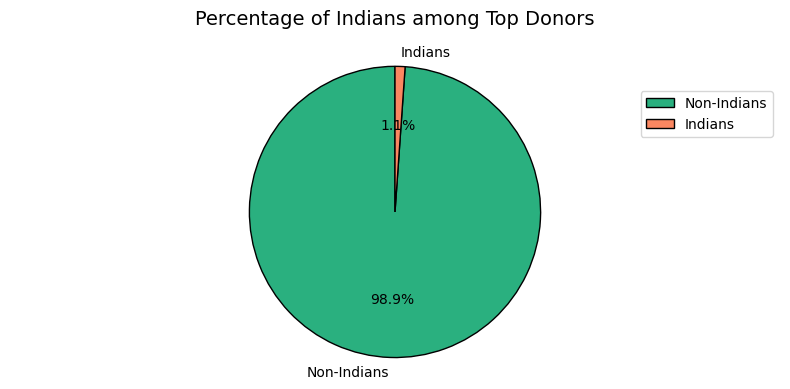

In [143]:
indian_counts = top_donors_actual['indian'].value_counts()

plt.figure(figsize=(8, 4))
plt.pie(indian_counts, 
        labels=['Non-Indians', 'Indians'], 
        colors=['#2ab07f', '#fb8761'], 
        autopct='%1.1f%%', 
        startangle=90,
        wedgeprops={'linewidth': 1, 'edgecolor': 'black'},
        textprops={'fontsize': 10})

plt.title('Percentage of Indians among Top Donors', pad=20, fontsize=14)
plt.axis('equal')
plt.legend(loc='upper right', bbox_to_anchor=(1, 0.9))
plt.tight_layout()
plt.show()

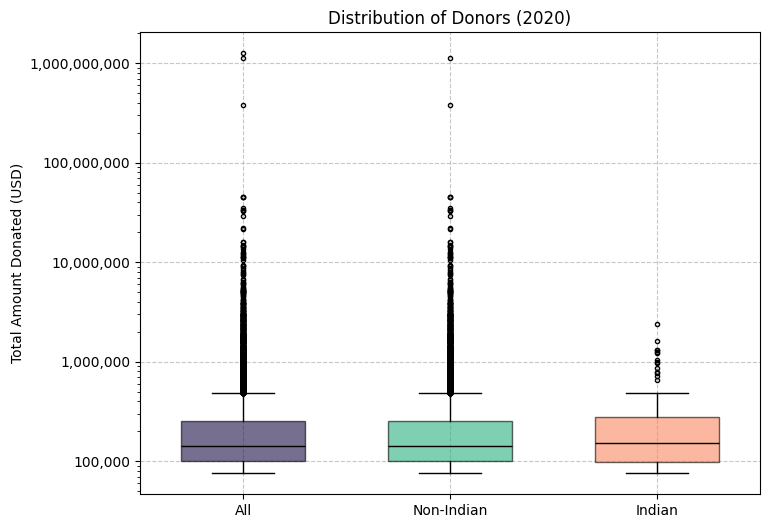

In [129]:
amounts_all = top_donors_actual['total_donated']
amounts_non_indian = top_donors_actual[top_donors_actual['indian'] == False]['total_donated']
amounts_indian = top_donors_actual[top_donors_actual['indian'] == True]['total_donated']

plt.figure(figsize=(8, 6))
plot = plt.boxplot([amounts_all, amounts_non_indian, amounts_indian], 
                   tick_labels=["All", "Non-Indian", "Indian"], 
                   patch_artist=True, 
                   widths=0.6, 
                   medianprops={"color": "black", "linewidth": 1}, 
                   flierprops={"marker": "o", "markersize": 3})

colors = ["#1b1044", "#2ab07f", "#fb8761"]
for patch, color in zip(plot["boxes"], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)

plt.title("Distribution of Donors (2020)")
plt.ylabel("Total Amount Donated (USD)")
plt.yscale("log")
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()

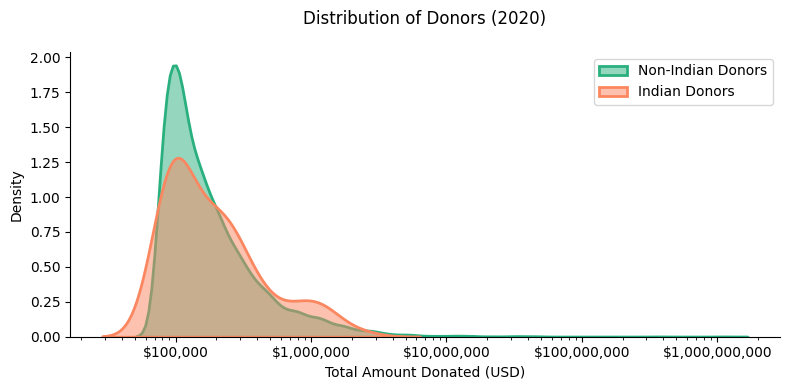

In [130]:
plt.figure(figsize=(8, 4))

sns.kdeplot(data=top_donors_actual[top_donors_actual['indian'] == False]['total_donated'],
            label='Non-Indian Donors',
            color='#2ab07f',
            fill=True,
            alpha=0.5,
            linewidth=2,
            log_scale=True)
sns.kdeplot(data=top_donors_actual[top_donors_actual['indian'] == True]['total_donated'],
            label='Indian Donors',
            color='#fb8761',
            fill=True,
            alpha=0.5,
            linewidth=2,
            log_scale=True)

plt.title("Distribution of Donors (2020)", pad=20)
plt.xlabel("Total Amount Donated (USD)")
plt.ylabel("Density")
plt.xscale('log')

plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'${x:,.0f}'))
plt.legend()
sns.despine()
plt.tight_layout()
plt.show()

In [ ]:
# print(df.filter(pl.col("is_indian") == True)["name"].value_counts())

shape: (56_516, 2)
┌─────────────────┬───────┐
│ name            ┆ count │
│ ---             ┆ ---   │
│ str             ┆ u32   │
╞═════════════════╪═══════╡
│ bhatti, farhan  ┆ 28    │
│ james, jan      ┆ 10    │
│ taggart, join   ┆ 3     │
│ rains, jana     ┆ 1     │
│ yepuri, venkat  ┆ 4     │
│ …               ┆ …     │
│ karim, mohammad ┆ 2     │
│ bansal, ritu    ┆ 7     │
│ mathrani, kiran ┆ 1     │
│ bennett, joni   ┆ 2     │
│ kale, hemant    ┆ 1     │
└─────────────────┴───────┘


In [24]:
amounts_all = df["amount"].to_list()
amounts_indian = df.filter(pl.col("is_indian") == True)["amount"].to_list()
amounts_non_indian = df.filter(pl.col("is_indian") == False)["amount"].to_list()

In [25]:
region_mapping = {
    "CT": "Northeast", "ME": "Northeast", "MA": "Northeast", "NH": "Northeast",
    "NJ": "Northeast", "NY": "Northeast", "PA": "Northeast", "RI": "Northeast", "VT": "Northeast",
    
    "IL": "Midwest", "IN": "Midwest", "IA": "Midwest", "KS": "Midwest", "MI": "Midwest",
    "MN": "Midwest", "MO": "Midwest", "NE": "Midwest", "ND": "Midwest", "OH": "Midwest",
    "SD": "Midwest", "WI": "Midwest",
    
    "AL": "South", "AR": "South", "DE": "South", "FL": "South", "GA": "South",
    "KY": "South", "LA": "South", "MD": "South", "MS": "South", "NC": "South",
    "OK": "South", "SC": "South", "TN": "South", "TX": "South", "VA": "South", "WV": "South",
    
    "AK": "West", "AZ": "West", "CA": "West", "CO": "West", "HI": "West",
    "ID": "West", "MT": "West", "NV": "West", "NM": "West", "OR": "West",
    "UT": "West", "WA": "West", "WY": "West"
}

df = df.with_columns(pl.col("state").replace(region_mapping).alias("region"))

In [26]:
census_region_mapping = {
    "CT": "New England", "ME": "New England", "MA": "New England", 
    "NH": "New England", "RI": "New England", "VT": "New England",
    "NJ": "Mid-Atlantic", "NY": "Mid-Atlantic", "PA": "Mid-Atlantic",

    "IL": "Great Lakes", "IN": "Great Lakes", "MI": "Great Lakes", 
    "OH": "Great Lakes", "WI": "Great Lakes",
    "IA": "Plains", "KS": "Plains", "MN": "Plains", 
    "MO": "Plains", "NE": "Plains", "ND": "Plains", "SD": "Plains",

    "DE": "South Atlantic", "FL": "South Atlantic", "GA": "South Atlantic", 
    "MD": "South Atlantic", "NC": "South Atlantic", "SC": "South Atlantic", 
    "VA": "South Atlantic", "WV": "South Atlantic", "DC": "South Atlantic",
    "AL": "Deep South", "KY": "Deep South", "MS": "Deep South", "TN": "Deep South",
    "AR": "Gulf Coast", "LA": "Gulf Coast", "OK": "Gulf Coast", "TX": "Gulf Coast",

    "AZ": "Mountain West", "CO": "Mountain West", "ID": "Mountain West", 
    "MT": "Mountain West", "NV": "Mountain West", "NM": "Mountain West", 
    "UT": "Mountain West", "WY": "Mountain West",
    "AK": "Pacific", "CA": "Pacific", "HI": "Pacific", 
    "OR": "Pacific", "WA": "Pacific"
}

df = df.with_columns(pl.col("state").replace(census_region_mapping).alias("census_region"))

In [27]:
amounts = []
regions = list(dict.fromkeys(region_mapping.values()))

amounts.append(df["amount"].to_list())
for region in regions:
    amounts.append(df.filter(pl.col("region") == region)["amount"].to_list())

In [28]:
census_amounts = []
census_regions = list(dict.fromkeys(census_region_mapping.values()))

census_amounts.append(df["amount"].to_list())
for census_region in census_regions:
    census_amounts.append(df.filter(pl.col("census_region") == census_region)["amount"].to_list())

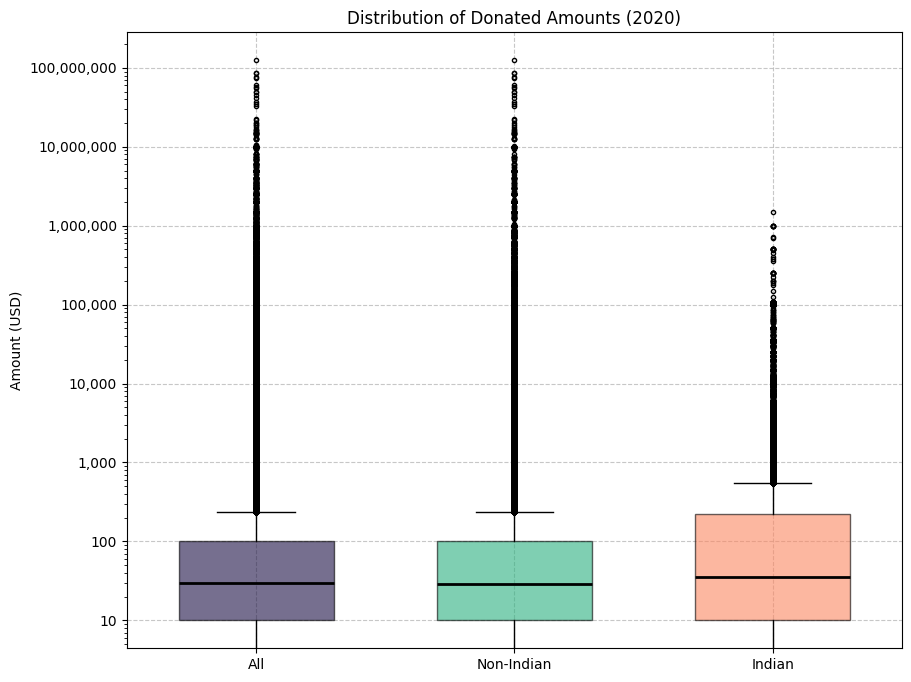

In [29]:
plt.figure(figsize=(10, 8))
plot = plt.boxplot([amounts_all, amounts_non_indian, amounts_indian], tick_labels=["All", "Non-Indian", "Indian"], patch_artist=True, widths=0.6, medianprops={"color": "black", "linewidth": 2}, flierprops={"marker": "o", "markersize": 3})

colors = ["#1b1044", "#2ab07f", "#fb8761"]
for patch, color in zip(plot["boxes"], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)

plt.title("Distribution of Donated Amounts (2020)")
plt.ylabel("Amount (USD)")
plt.yscale("log")
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()

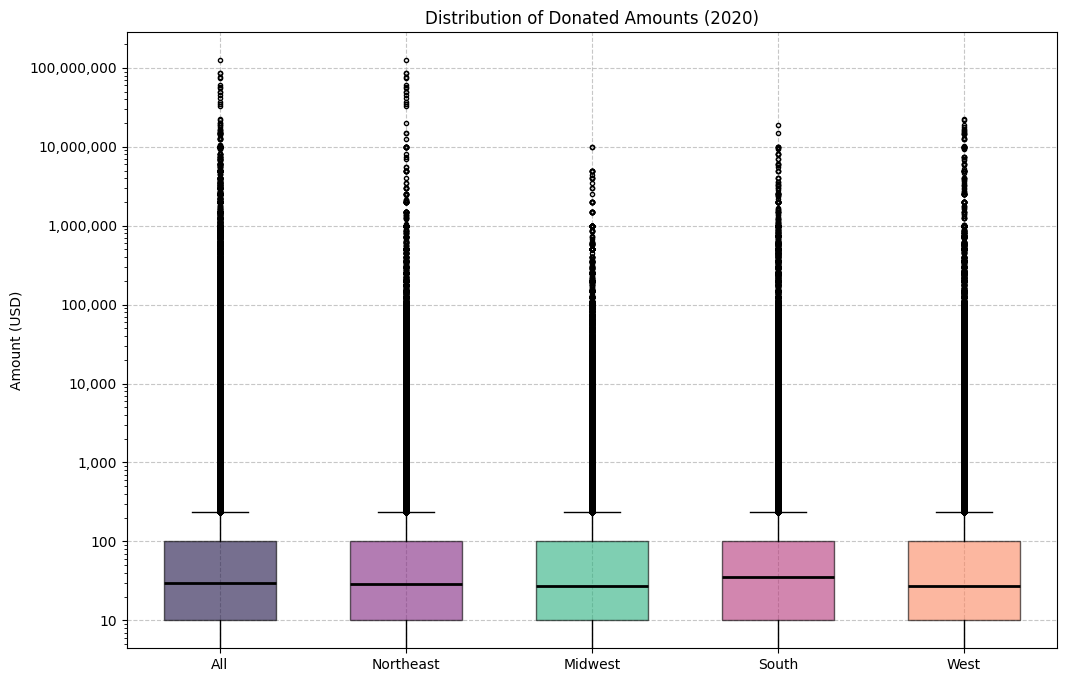

In [30]:
plt.figure(figsize=(12, 8))
plot = plt.boxplot(amounts, tick_labels=["All"] + regions, patch_artist=True, widths=0.6, medianprops={"color": "black", "linewidth": 2}, flierprops={"marker": "o", "markersize": 3})

colors = ["#1b1044", "#812581", "#2ab07f", "#b5367a", "#fb8761"]
for patch, color in zip(plot["boxes"], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)

plt.title("Distribution of Donated Amounts (2020)")
plt.ylabel("Amount (USD)")
plt.yscale("log")
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()

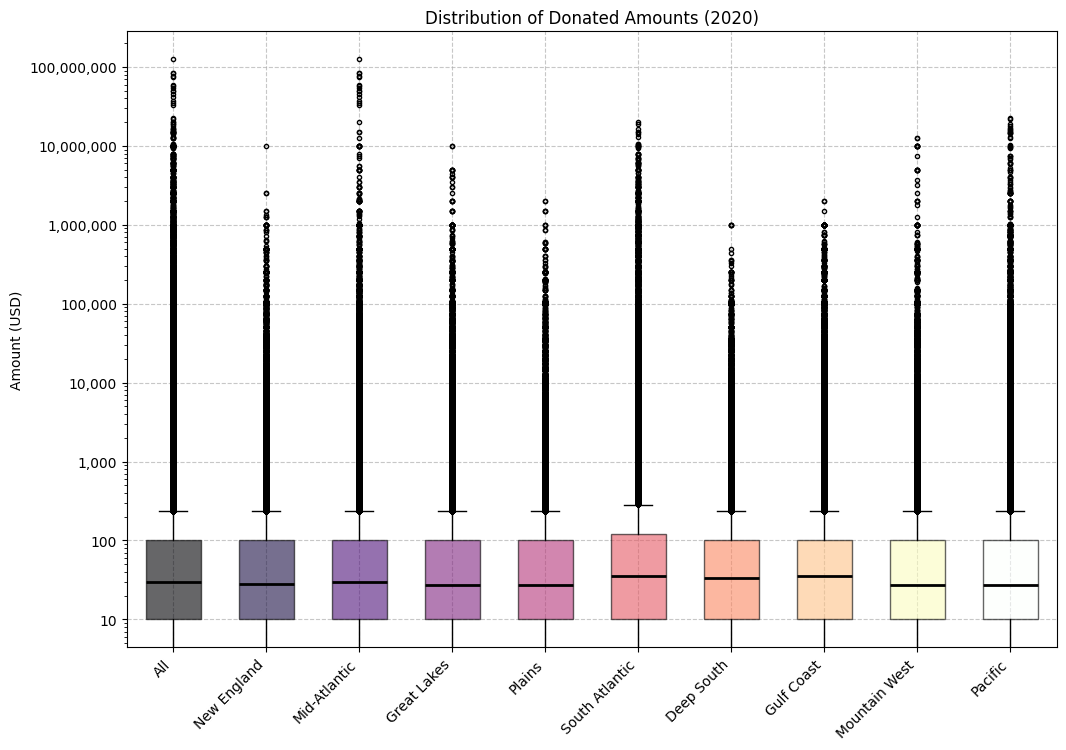

In [31]:
plt.figure(figsize=(12, 8))
plot = plt.boxplot(census_amounts, tick_labels=["All"] + census_regions, patch_artist=True, widths=0.6, medianprops={"color": "black", "linewidth": 2}, flierprops={"marker": "o", "markersize": 3})

colors = ["#000004", "#1b1044", "#4f127b", "#812581", "#b5367a", "#e55964", "#fb8761", "#fec287", "#fbfdbf", "#fcfffd"]
for patch, color in zip(plot["boxes"], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)

plt.title("Distribution of Donated Amounts (2020)")
plt.ylabel("Amount (USD)")
plt.yscale("log")
plt.xticks(rotation=45, ha='right')
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()

In [ ]:
plt.figure(figsize=(12, 8))
plot = plt.boxplot(census_amounts, tick_labels=["All"] + census_regions, patch_artist=True, widths=0.6, medianprops={"color": "black", "linewidth": 2}, flierprops={"marker": "o", "markersize": 3})

colors = ["#000004", "#1b1044", "#4f127b", "#812581", "#b5367a", "#e55964", "#fb8761", "#fec287", "#fbfdbf", "#fcfffd"]
for patch, color in zip(plot["boxes"], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)

plt.title("Distribution of Donated Amounts (2020)")
plt.ylabel("Amount (USD)")
plt.yscale("log")
plt.ylim(0, 1000)
plt.xticks(rotation=45, ha='right')
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()

C:\Users\karnav\AppData\Local\Temp\ipykernel_18144\2497341411.py:12: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0, 1000)


MemoryError: Unable to allocate 117. MiB for an array with shape (2, 7694461) and data type float64

<Figure size 1200x800 with 1 Axes>

: 

In [ ]:
state_stats = (
    df.group_by("state")
    .agg(
        pl.col("amount").mean().alias("avg_amount"),
        pl.col("amount").median().alias("med_amount"),
        pl.col("amount").count().alias("total_donations"),
        pl.col("amount").filter(pl.col("is_indian")).mean().alias("avg_amount_indian"),
        pl.col("amount").filter(pl.col("is_indian")).median().alias("med_amount_indian"),
        pl.col("amount").filter(pl.col("is_indian")).count().alias("indian_donations")
    )
    .sort("avg_amount", descending=True)
)

In [ ]:
import geopandas as gpd

# Load U.S. states geometry (Natural Earth dataset)
url = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_1_states_provinces.zip"
gdf = gpd.read_file(url)

exclude_codes = ["US-AK", "US-HI", "US-PR", "US-GU", "US-VI", "US-AS", "US-MP"]
gdf = gdf[(gdf["iso_a2"] == "US") & (~gdf["iso_3166_2"].isin(exclude_codes))][["iso_3166_2", "name", "geometry"]]
gdf["state"] = gdf["iso_3166_2"].str.replace("US-", "")
gdf_merged = gdf.merge(state_stats.to_pandas(), on="state", how="left")

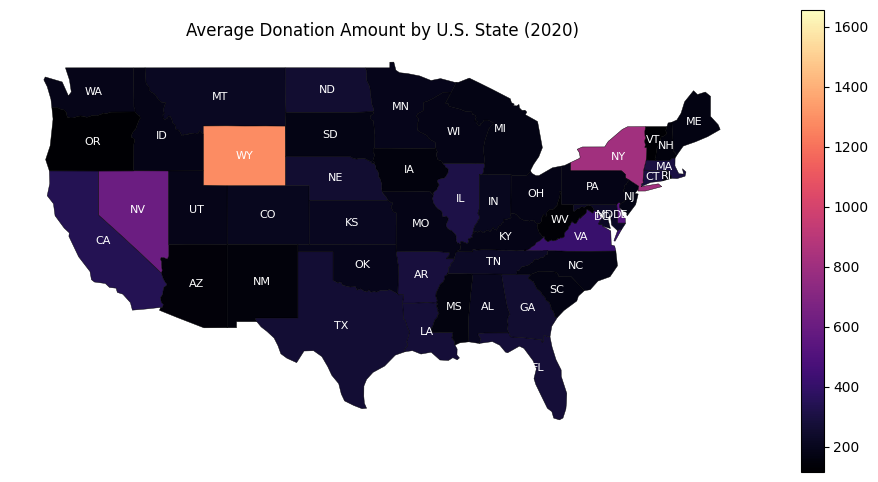

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
gdf_merged.plot(
    column="avg_amount",
    cmap="magma",
    legend=True,
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    missing_kwds={"color": "lightgray"}
)

for idx, row in gdf_merged.iterrows():
    centroid = row["geometry"].centroid
    ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="white")

plt.title("Average Donation Amount by U.S. State (2020)")
plt.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")
plt.show()

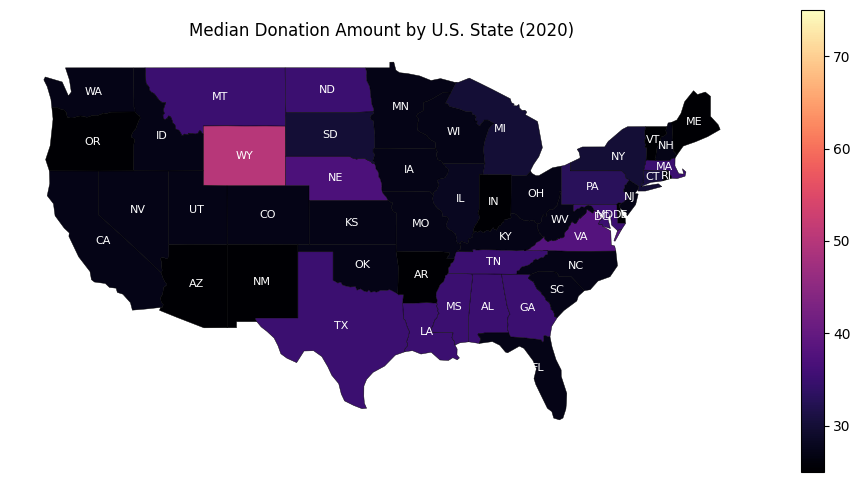

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
gdf_merged.plot(
    column="med_amount",
    cmap="magma",
    legend=True,
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    missing_kwds={"color": "lightgray"}
)

for idx, row in gdf_merged.iterrows():
    centroid = row["geometry"].centroid
    ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="white")

plt.title("Median Donation Amount by U.S. State (2020)")
plt.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")
plt.show()

In [ ]:
print(df.filter(pl.col("state") == "WY").sort("amount", descending=True))

shape: (63_697, 10)
┌────────────┬────────────┬───────────┬───────────┬───┬───────────┬───────────┬────────┬───────────┐
│ contrib_id ┆ name       ┆ recip_id  ┆ amount    ┆ … ┆ recipcode ┆ is_indian ┆ region ┆ census_re │
│ ---        ┆ ---        ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---    ┆ gion      │
│ str        ┆ str        ┆ str       ┆ f64       ┆   ┆ str       ┆ bool      ┆ str    ┆ ---       │
│            ┆            ┆           ┆           ┆   ┆           ┆           ┆        ┆ str       │
╞════════════╪════════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪════════╪═══════════╡
│ U000000468 ┆ mellon,    ┆ C00637512 ┆ 1e7       ┆ … ┆ OI        ┆ false     ┆ West   ┆ Mountain  │
│ 41         ┆ timothy    ┆           ┆           ┆   ┆           ┆           ┆        ┆ West      │
│ U000000468 ┆ mellon,    ┆ C00504530 ┆ 1e7       ┆ … ┆ OI        ┆ false     ┆ West   ┆ Mountain  │
│ 41         ┆ timothy    ┆           ┆           ┆   ┆           ┆    

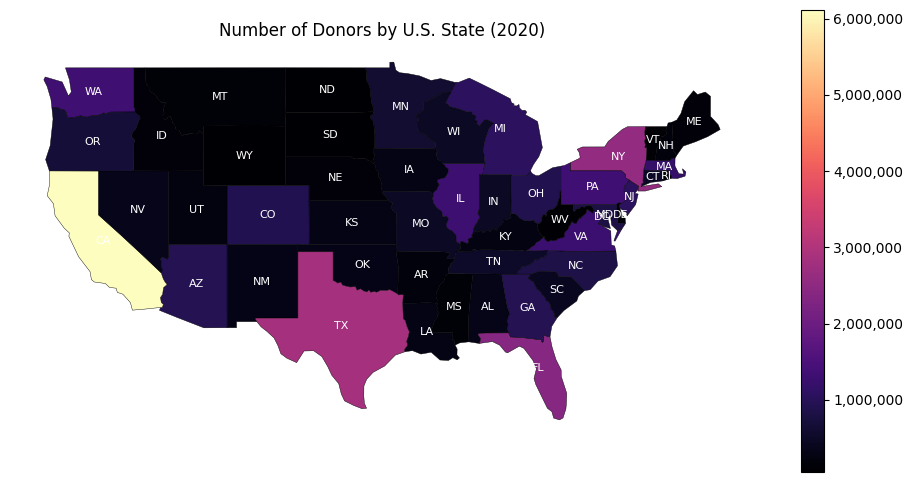

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
gdf_merged.plot(
    column="total_donations",
    cmap="magma",
    legend=True,
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    missing_kwds={"color": "lightgray"}
)

cbar = fig.axes[-1]
cbar.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:,.0f}"))

for idx, row in gdf_merged.iterrows():
    centroid = row["geometry"].centroid
    ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="white")

plt.title("Number of Donors by U.S. State (2020)")
plt.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")
plt.show()

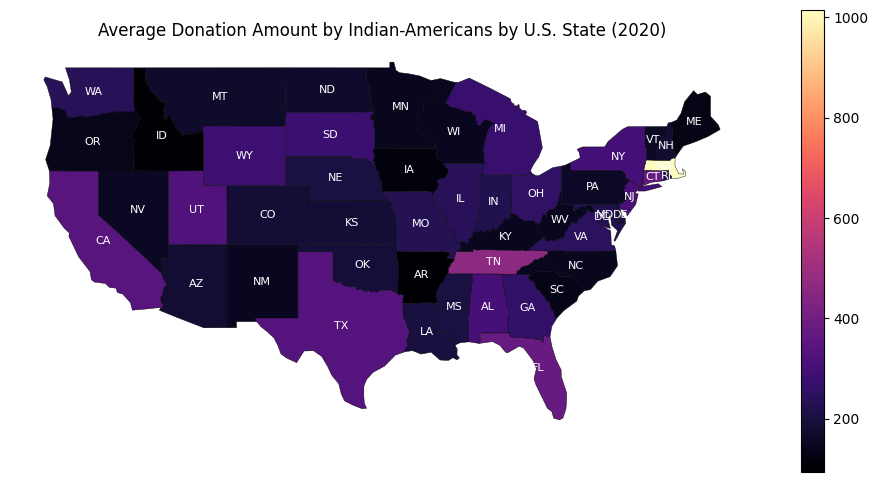

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
gdf_merged.plot(
    column="avg_amount_indian",
    cmap="magma",
    legend=True,
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    missing_kwds={"color": "lightgray"}
)

for idx, row in gdf_merged.iterrows():
    centroid = row["geometry"].centroid
    ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="white")

plt.title("Average Donation Amount by Indian-Americans by U.S. State (2020)")
plt.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")
plt.show()

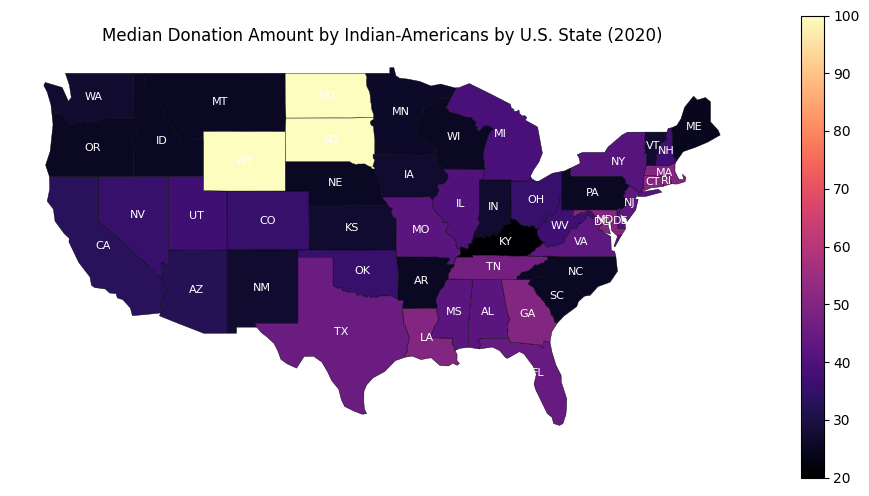

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
gdf_merged.plot(
    column="med_amount_indian",
    cmap="magma",
    legend=True,
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    missing_kwds={"color": "lightgray"}
)

for idx, row in gdf_merged.iterrows():
    centroid = row["geometry"].centroid
    ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="white")

plt.title("Median Donation Amount by Indian-Americans by U.S. State (2020)")
plt.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")
plt.show()

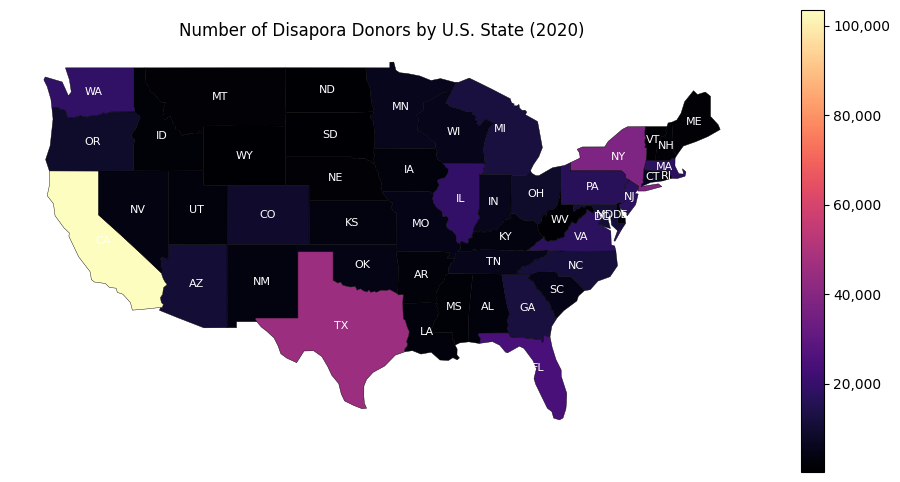

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
gdf_merged.plot(
    column="indian_donations",
    cmap="magma",
    legend=True,
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    missing_kwds={"color": "lightgray"}
)

cbar = fig.axes[-1]
cbar.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:,.0f}"))

for idx, row in gdf_merged.iterrows():
    centroid = row["geometry"].centroid
    ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="white")

plt.title("Number of Disapora Donors by U.S. State (2020)")
plt.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")
plt.show()

In [ ]:
cands20 = "./data/CampaignFin20/cands20.txt"
temp = (
        pl.scan_csv(
            cands20,
            separator=',', 
            quote_char='|', 
            encoding='utf8-lossy', 
            has_header=False,
            ignore_errors=True
        )
        # .select(['contrib_id', 'name', 'recip_id', 'amount', 'city', 'state', 'recipcode'])
        # .filter(~pl.col('amount').is_null())
    )
cands = temp.collect()
cands = cands.rename({"column_3": "recip_id"})
print(cands.head(10))

shape: (10, 12)
┌──────────┬───────────┬───────────┬────────────┬───┬──────────┬───────────┬───────────┬───────────┐
│ column_1 ┆ column_2  ┆ column_3  ┆ column_4   ┆ … ┆ column_9 ┆ column_10 ┆ column_11 ┆ column_12 │
│ ---      ┆ ---       ┆ ---       ┆ ---        ┆   ┆ ---      ┆ ---       ┆ ---       ┆ ---       │
│ i64      ┆ str       ┆ str       ┆ str        ┆   ┆ str      ┆ str       ┆ str       ┆ str       │
╞══════════╪═══════════╪═══════════╪════════════╪═══╪══════════╪═══════════╪═══════════╪═══════════╡
│ 2020     ┆ H0AK00105 ┆ N00039029 ┆ Thomas     ┆ … ┆ Y        ┆ C         ┆ 3N        ┆           │
│          ┆           ┆           ┆ Lamb (I)   ┆   ┆          ┆           ┆           ┆           │
│ 2020     ┆ H0AK00113 ┆ N00047445 ┆ Ray Sean   ┆ … ┆ Y        ┆ C         ┆ DL        ┆           │
│          ┆           ┆           ┆ Tugatuk    ┆   ┆          ┆           ┆           ┆           │
│          ┆           ┆           ┆ (D)        ┆   ┆          ┆           

In [36]:
df.filter(pl.col("recip_id") == "N00023864")

dummy1,dummy2,contrib_id,name,recip_id,orgname,ultorg,realcode,dummy3,amount,street,city,state,zip,recipcode,type,dummy4,dummy5,gender,dummy6,occupation,employer,dummy7
i64,i64,str,str,str,str,str,str,str,f64,str,str,str,i64,str,str,str,str,str,i64,str,str,str
2020,4010620212062489531,"""g1100638025 ""","""SCARINGE, CHRIS""","""N00023864""","""North American Industrial Serv…","""""","""Y4000""","""11/15/2020""",475.0,"""""","""COHOES""","""NY""",12047,"""RL""","""15E""","""C00580100""","""""","""M""",202012179393273653,"""ATTORNEY""","""NORTH ANERICAN""",""" """
2020,4050420201741556264,"""h3001862539 ""","""AAVIK, HELEN""","""N00023864""","""Retired""","""""","""X1200""","""01/28/2020""",100.0,"""""","""CHICAGO""","""IL""",60605,"""RL""","""15E""","""C00580100""","""""","""F""",202004279232298947,"""RETIRED""","""RETIRED""","""Gen """
2020,4050420201741556272,"""q0000329527 ""","""ABBETT, DAWNRTTA""","""N00023864""","""A&L Home Care""","""""","""Z9600""","""01/30/2020""",250.0,"""""","""LAVALETTE""","""WV""",25535,"""RL""","""15E""","""C00580100""","""C00694323""","""U""",202004279232298950,"""RNCEO""","""A&L HOME CARE""","""RptEF"""
2020,4050420201741556275,"""p0003099311 ""","""ABBONDANZIO, GIOVANNI""","""N00023864""","""All County Insurance""","""""","""F3100""","""01/28/2020""",250.0,"""""","""JUPITER""","""FL""",33477,"""RL""","""15 ""","""C00580100""","""""","""M""",202004279232298951,"""OWNER""","""ALL COUNTY INSURANCE""","""Name """
2020,4050420201741556283,"""p0005388870 ""","""ABBOTT, PHILLIP""","""N00023864""","""Atlantis Aromatics""","""""","""J1100""","""01/07/2020""",250.0,"""""","""MANASQUAN""","""NJ""",8736,"""RL""","""15 ""","""C00580100""","""""","""M""",202004279232298953,"""OWNER""","""ATLANTIS AROMATICS INC""",""" """
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2020,4021920211159107530,"""q0001271772 ""","""ZWEIG, FELICE""","""N00023864""","""Retired""","""""","""X1200""","""08/15/2020""",237.0,"""""","""DOTHAN""","""AL""",36305,"""RL""","""15J""","""C00580100""","""""","""F""",null,"""RETIRED""","""RETIRED""","""Gen """
2020,4021920211159107535,"""e1110797569 ""","""ZWINGELBERG, KEITH""","""N00023864""","""White Sands Anesthesia & Pain …","""""","""H1130""","""08/04/2020""",750.0,"""""","""PANAMA CITY""","""FL""",32401,"""RL""","""15J""","""C00580100""","""""","""M""",null,"""PHYSICIAN""","""WHITE SANDS ANESTHESIA AND PAI…","""Name """
2020,4021920211159107536,"""r0015200198 ""","""ZWISLER, GERALD""","""N00023864""","""11th Ave Investments""","""""","""F2000""","""08/21/2020""",950.0,"""""","""LONGMONT""","""CO""",80502,"""RL""","""15J""","""C00580100""","""""","""M""",null,"""INFORMATION REQUESTED PER BEST…","""11TH AVE INVESTMENTS""","""temp """


In [19]:
indian_donor_names = top_donors_actual[top_donors_actual["indian"] == True]["name"].apply(lambda x: str(x).upper()).to_list()
print(df.filter(pl.col("name").is_in(indian_donor_names)))

shape: (4_979, 23)
┌────────┬────────────┬────────────┬────────────┬───┬────────────┬────────────┬───────────┬────────┐
│ dummy1 ┆ dummy2     ┆ contrib_id ┆ name       ┆ … ┆ dummy6     ┆ occupation ┆ employer  ┆ dummy7 │
│ ---    ┆ ---        ┆ ---        ┆ ---        ┆   ┆ ---        ┆ ---        ┆ ---       ┆ ---    │
│ i64    ┆ i64        ┆ str        ┆ str        ┆   ┆ i64        ┆ str        ┆ str       ┆ str    │
╞════════╪════════════╪════════════╪════════════╪═══╪════════════╪════════════╪═══════════╪════════╡
│ 2020   ┆ 4030220201 ┆ h300122040 ┆ MULYE,     ┆ … ┆ 2020012991 ┆ PHARMACEUT ┆ NOSTRUM   ┆ Rept   │
│        ┆ 223235099  ┆ 0          ┆ NIRMAL     ┆   ┆ 72668637   ┆ ICALS      ┆ PHARMACEU ┆        │
│        ┆            ┆            ┆            ┆   ┆            ┆            ┆ TICALS    ┆        │
│ 2020   ┆ 4030220201 ┆ e111080026 ┆ RAJ,       ┆ … ┆ 2020012991 ┆ INVESTMENT ┆ RAJ ASSOC ┆ Rept   │
│        ┆ 223689277  ┆ 31         ┆ DEEPAK     ┆   ┆ 73428428   ┆ S    

In [ ]:
recipients_indian_dons = df.filter(pl.col("name").is_in(indian_donor_names))["recip_id"].to_list()
cands_indian_donors = cands.filter(pl.col("column_3").is_in(recipients_indian_dons))
cands_indian_donors = cands_indian_donors.rename({"column_3": "recip_id"})
cands_indian_donors

column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11,column_12
i64,str,str,str,str,str,str,str,str,str,str,str
2020,"""H0AL02178""","""N00045630""","""Jessica Taylor (R)""","""R""","""AL02""",""" """,""" ""","""Y""","""O""","""RL""",""" """
2020,"""H0AR02206""","""N00031717""","""Joyce Elliott (D)""","""D""","""AR02""",""" ""","""Y""","""Y""","""C""","""DL""",""" """
2020,"""H0CA03078""","""N00030717""","""Ami Bera (D)""","""D""","""CA07""","""CA07""","""Y""","""Y""","""I""","""DW""",""" """
2020,"""H0CA08135""","""N00045377""","""Jay Obernolte (R)""","""R""","""CA08""",""" ""","""Y""","""Y""","""O""","""RW""",""" """
2020,"""H0CA12137""","""N00044754""","""Deanna Lorraine (R)""","""R""","""CA12""",""" """,""" ""","""Y""","""C""","""RL""",""" """
…,…,…,…,…,…,…,…,…,…,…,…
2020,"""S8NV00156""","""N00038734""","""Jacky Rosen (D)""","""D""","""NVS1""","""NVS1""",""" """,""" ""","""I""","""DI""",""" """
2020,"""S8NY00082""","""N00001093""","""Charles E Schumer (D)""","""D""","""NYS2""","""NYS2""",""" """,""" ""","""I""","""DI""",""" """
2020,"""S8TX00285""","""N00033540""","""Beto O'Rourke (D)""","""D""","""PRES""",""" """,""" """,""" ""","""C""","""DL""",""" """


In [21]:
cands_indian_donors["column_4"].value_counts().sort(by="count", descending=True)

column_4,count
str,u32
"""Beto O'Rourke (D)""",3
"""Richard Ojeda (D)""",3
"""Kamala Harris (D)""",2
"""Ben Ray Lujan (D)""",2
"""Nate McMurray (D)""",2
…,…
"""Pete Olson (R)""",1
"""Daniel Feehan (D)""",1
"""Rita Hart (D)""",1


In [22]:
cands_indian_donors["column_5"].value_counts().sort(by="count", descending=True)

column_5,count
str,u32
"""D""",258
"""R""",109
"""I""",4


In [23]:
cands_indian_donors["column_11"].value_counts().sort(by="count", descending=True)

column_11,count
str,u32
"""DW""",120
"""DL""",110
"""RW""",63
"""RL""",32
"""DI""",21
…,…
"""DC""",3
"""3I""",2
"""3L""",2


In [24]:
cands_indian_donors["column_10"].value_counts().sort(by="count", descending=True)

column_10,count
str,u32
"""I""",212
"""C""",108
"""O""",49
""" """,2


In [25]:
cands_indian_donors["column_6"].value_counts().sort(by="count", descending=True)

column_6,count
str,u32
"""PRES""",14
"""COS2""",7
"""TXS1""",4
"""MTS2""",4
"""MAS2""",4
…,…
"""KS03""",1
"""IN02""",1
"""NY23""",1


In [ ]:
donations_total = (
    df.group_by("recip_id")
    .agg(pl.sum("amount").alias("total_amount"))
)

result = cands.join(
    donations_total,
    on="recip_id",
    how="left"
).fill_null(0)

result = result.sort("total_amount", descending=True)
result

column_1,column_2,recip_id,column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11,column_12,total_amount
i64,str,str,str,str,str,str,str,str,str,str,str,f64
2020,"""P00014530""","""N00029349""","""Michael Bloomberg (D)""","""D""","""PRES""",""" """,""" ""","""Y""","""C""","""DL""",""" """,1.0866e9
2020,"""P80000722""","""N00001669""","""Joe Biden (D)""","""D""","""PRES""",""" ""","""Y""","""Y""","""C""","""DW""",""" """,6.66461935e8
2020,"""P80001571""","""N00023864""","""Donald Trump (R)""","""R""","""PRES""","""PRES""","""Y""","""Y""","""I""","""RL""",""" """,4.04511427e8
2020,"""P00012716""","""N00044966""","""Tom Steyer (D)""","""D""","""PRES""",""" """,""" ""","""Y""","""C""","""DL""",""" """,3.1996642e8
2020,"""P60007168""","""N00000528""","""Bernie Sanders (D)""","""I""","""VTS1""",""" """,""" """,""" ""","""I""","""3I""",""" """,1.06916776e8
…,…,…,…,…,…,…,…,…,…,…,…,…
2020,"""H8FL27037""","""N00041091""","""Bruno Barreiro (R)""","""R""","""FL27""",""" """,""" """,""" """,""" ""","""RN""",""" """,-104763.0
2020,"""H8NY19223""","""N00041165""","""Pat Ryan (D)""","""D""","""NY19""",""" """,""" """,""" """,""" ""","""DN""",""" """,-116374.0
2020,"""H8NY07046""","""N00001127""","""Joseph Crowley (D)""","""D""","""NY14""",""" """,""" """,""" """,""" ""","""DN""",""" """,-169334.0


In [32]:
result[:10]

column_1,column_2,recip_id,column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11,column_12,total_amount
i64,str,str,str,str,str,str,str,str,str,str,str,f64
2020,"""P00014530""","""N00029349""","""Michael Bloomberg (D)""","""D""","""PRES""",""" """,""" ""","""Y""","""C""","""DL""",""" """,1.0866e9
2020,"""P80000722""","""N00001669""","""Joe Biden (D)""","""D""","""PRES""",""" ""","""Y""","""Y""","""C""","""DW""",""" """,6.66461935e8
2020,"""P80001571""","""N00023864""","""Donald Trump (R)""","""R""","""PRES""","""PRES""","""Y""","""Y""","""I""","""RL""",""" """,4.04511427e8
2020,"""P00012716""","""N00044966""","""Tom Steyer (D)""","""D""","""PRES""",""" """,""" ""","""Y""","""C""","""DL""",""" """,3.1996642e8
2020,"""P60007168""","""N00000528""","""Bernie Sanders (D)""","""I""","""VTS1""",""" """,""" """,""" ""","""I""","""3I""",""" """,1.06916776e8
2020,"""S4VT00033""","""N00000528""","""Bernie Sanders (D)""","""I""","""VTS1""","""VTS1""",""" """,""" ""","""I""","""3I""",""" """,1.06916776e8
2020,"""P00010298""","""N00044183""","""Pete Buttigieg (D)""","""D""","""PRES""",""" """,""" ""","""Y""","""C""","""DL""",""" """,8.216696e7
2020,"""H8GA06195""","""N00040675""","""Jon Ossoff (D)""","""D""","""GAS1""",""" """,""" """,""" ""","""C""","""DW""",""" """,7.3443851e7
2020,"""S8GA00180""","""N00040675""","""Jon Ossoff (D)""","""D""","""GAS1""",""" ""","""Y""","""Y""","""C""","""DW""",""" """,7.3443851e7


In [37]:
df_indian = df.filter(pl.col("name").is_in(indian_donor_names))
donations_total_indian = (
    df_indian.group_by("recip_id")
    .agg(pl.sum("amount").alias("total_amount"))
)

result_indian = cands.join(
    donations_total_indian,
    on="recip_id",
    how="left"
).fill_null(0)

result_indian = result_indian.sort("total_amount", descending=True)
result_indian

column_1,column_2,recip_id,column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11,column_12,total_amount
i64,str,str,str,str,str,str,str,str,str,str,str,f64
2020,"""S8MA00268""","""N00041034""","""Shiva Ayyadurai (R)""","""R""","""MAS2""",""" """,""" ""","""Y""","""C""","""RL""",""" """,1.0449e6
2020,"""P80000722""","""N00001669""","""Joe Biden (D)""","""D""","""PRES""",""" ""","""Y""","""Y""","""C""","""DW""",""" """,374163.0
2020,"""H8TX22313""","""N00042142""","""Sri Kulkarni (D)""","""D""","""TX22""",""" ""","""Y""","""Y""","""O""","""DL""",""" """,189093.0
2020,"""H8GA06195""","""N00040675""","""Jon Ossoff (D)""","""D""","""GAS1""",""" """,""" """,""" ""","""C""","""DW""",""" """,121650.0
2020,"""S8GA00180""","""N00040675""","""Jon Ossoff (D)""","""D""","""GAS1""",""" ""","""Y""","""Y""","""C""","""DW""",""" """,121650.0
…,…,…,…,…,…,…,…,…,…,…,…,…
2020,"""S8WY00189""","""N00027793""","""Gary Trauner (D)""","""D""","""WYS1""",""" """,""" """,""" """,""" ""","""DN""",""" """,0.0
2020,"""S8WY00197""","""N00042998""","""David Dodson (R)""","""R""","""WYS1""",""" """,""" """,""" """,""" ""","""RN""",""" """,0.0
2020,"""S8WY00213""","""N00043748""","""John Holtz (R)""","""R""","""WYS2""",""" """,""" ""","""Y""","""O""","""RL""",""" """,0.0


In [50]:
result_indian[:10]

column_1,column_2,recip_id,column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11,column_12,total_amount
i64,str,str,str,str,str,str,str,str,str,str,str,f64
2020,"""S8MA00268""","""N00041034""","""Shiva Ayyadurai (R)""","""R""","""MAS2""",""" """,""" ""","""Y""","""C""","""RL""",""" """,1.0449e6
2020,"""P80000722""","""N00001669""","""Joe Biden (D)""","""D""","""PRES""",""" ""","""Y""","""Y""","""C""","""DW""",""" """,374163.0
2020,"""H8TX22313""","""N00042142""","""Sri Kulkarni (D)""","""D""","""TX22""",""" ""","""Y""","""Y""","""O""","""DL""",""" """,189093.0
2020,"""H8GA06195""","""N00040675""","""Jon Ossoff (D)""","""D""","""GAS1""",""" """,""" """,""" ""","""C""","""DW""",""" """,121650.0
2020,"""S8GA00180""","""N00040675""","""Jon Ossoff (D)""","""D""","""GAS1""",""" ""","""Y""","""Y""","""C""","""DW""",""" """,121650.0
2020,"""P80001571""","""N00023864""","""Donald Trump (R)""","""R""","""PRES""","""PRES""","""Y""","""Y""","""I""","""RL""",""" """,118248.0
2020,"""H6IL08147""","""N00033240""","""Raja Krishnamoorthi (D)""","""D""","""IL08""","""IL08""","""Y""","""Y""","""I""","""DW""",""" """,79500.0
2020,"""P00010520""","""N00044206""","""John Hickenlooper (D)""","""D""","""COS2""",""" """,""" """,""" ""","""C""","""DW""",""" """,74733.0
2020,"""S0CO00575""","""N00044206""","""John Hickenlooper (D)""","""D""","""COS2""",""" ""","""Y""","""Y""","""C""","""DW""",""" """,74733.0


In [51]:
result_indian["total_amount"].sum()

5384017.0

In [54]:
top_donors_actual[top_donors_actual["indian"] == True]["total_donated"].sum()

32849031

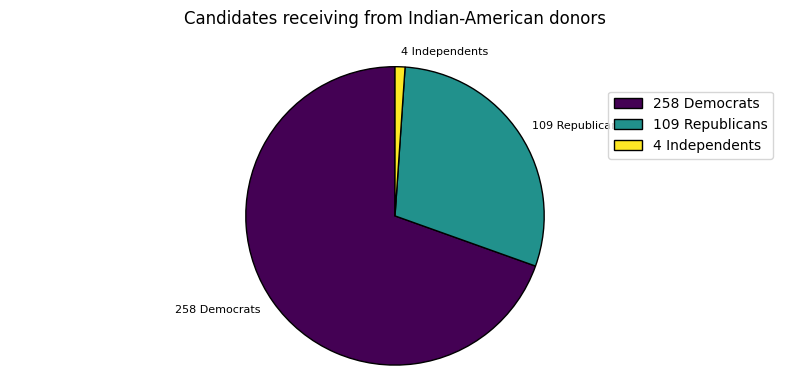

In [12]:
labels = ['258 Democrats', '109 Republicans', '4 Independents']
sizes = [258, 109, 4]

plt.figure(figsize=(8, 4))
plt.pie(sizes, 
        labels=labels, 
        colors=["#440154", "#21918c", "#fde725"], 
        startangle=90,
        wedgeprops={'linewidth': 1, 'edgecolor': 'black'},
        textprops={'fontsize': 8})

plt.title('Candidates receiving from Indian-American donors', pad=20, fontsize=12)
plt.axis('equal')
plt.legend(loc='upper right', bbox_to_anchor=(1, 0.9))
plt.tight_layout()
plt.show()